In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
cameraman = "C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/cameraman.png"
peppers = "C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/peppers.png"

In [23]:
camera = Image.open(cameraman).convert('RGB')  # Color image
cameraman_array = np.array(camera)
pepper = Image.open(peppers).convert('RGB')  # Color image
peppers_array = np.array(pepper)

In [24]:
def plot_images(original_image, encrypted_image, decrypted_image, shape):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(original_image.reshape(shape))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(encrypted_image.reshape(shape))
    axes[1].set_title("Encrypted Image")
    axes[1].axis('off')

    axes[2].imshow(decrypted_image.reshape(shape))
    axes[2].set_title("Decrypted Image")
    axes[2].axis('off')

    difference_image = np.abs(original_image - decrypted_image)
    axes[3].imshow(difference_image.reshape(shape))
    axes[3].set_title("Difference Image")
    axes[3].axis('off')

    plt.show()

In [25]:

from PIL import Image

import wave
import struct


def compute_image_characteristics(image_array):
    avg_intensity = np.mean(image_array)  # Average pixel intensity
    variance = np.var(image_array)  # Variance of pixel intensity
    histogram, _ = np.histogram(image_array, bins=256, range=(0, 255))
    probabilities = histogram / np.sum(histogram)
    entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)  # Entropy calculation
    return avg_intensity, variance, entropy

def determine_block_size(image_shape):
    print(image_shape)
    
    
    height, width = 0,0 # Height and width

    # If image is grayscale, you might need to handle the shape accordingly:
    if len(image_shape)==1:
        height,wieght = image_shape,0
        
    elif len(image_shape) == 2:
        height, width = image_shape  # Grayscale image with just (height, width)
    else:
        height, width = image_shape[:2] 
        
    smaller_dim = min(height, width)    
    if smaller_dim <200:
        return 1
    if smaller_dim < 512:
        return 16  # Small images
    elif smaller_dim <= 2048:
        return 64  # Medium images
    else:
        return 64 # Large images

def divide_into_blocks(image_array, block_size):
    height, width, channels = image_array.shape
    padded_height = (height + block_size - 1) // block_size * block_size
    padded_width = (width + block_size - 1) // block_size * block_size

    padded_image = np.zeros((padded_height, padded_width, channels), dtype=image_array.dtype)
    padded_image[:height, :width, :] = image_array

    blocks = []
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            blocks.append(padded_image[i:i + block_size, j:j + block_size])
    return blocks, (height, width), (padded_height, padded_width)

def merge_blocks(blocks, original_shape, padded_shape, block_size):
    padded_height, padded_width = padded_shape
    merged_image = np.zeros((padded_height, padded_width, blocks[0].shape[2]), dtype=blocks[0].dtype)

    block_index = 0
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            merged_image[i:i + block_size, j:j + block_size] = blocks[block_index]
            block_index += 1

    return merged_image[:original_shape[0], :original_shape[1], :]

def generate_chen_keys(size, avg_intensity, variance):
    x, y, z = avg_intensity / 255.0, variance / 255.0, 0.1  # Dynamic initialization
    a, b, c = 35 + avg_intensity % 10, 3 + variance % 5, 28  # Adjusted parameters
    keys = []
    for _ in range(size):
        dx = a * (y - x)
        dy = x * (c - z) - y
        dz = x * y - b * z
        x += dx * 0.01
        y += dy * 0.01
        z += dz * 0.01
        keys.append(x)
    return np.abs(np.array(keys)) % 256  # Normalize keys to range [0, 255]

def generate_lorenz_keys(size, avg_intensity, entropy):
    x, y, z = avg_intensity / 255.0, 0.5, entropy / 10.0  # Dynamic initialization
    sigma, rho, beta = 10 + entropy % 5, 28 + avg_intensity % 10, 2.667
    keys = []
    for _ in range(size):
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        x += dx * 0.01
        y += dy * 0.01
        z += dz * 0.01
        keys.append(y)
    return np.abs(np.array(keys)) % 256

def generate_logistic_keys(size, variance, entropy):
    x = np.clip(variance / 255.0, 0.01, 0.99)  
    r = np.clip(3.99 - (entropy % 0.1), 3.57, 4.0)  
    keys = []
    for _ in range(size):
        x = r * x * (1 - x)  
        keys.append(x)
    return (np.array(keys) * 255).astype(np.uint8)

def generate_dynamic_sbox(size, hybrid_keys):
    chaotic_sequence = hybrid_keys[:size]
    return np.argsort(chaotic_sequence)

def encrypt_block_cbc(block, hybrid_keys, sbox, previous_block):
    flat_block = block.flatten()

    xor_block = flat_block ^ previous_block.flatten()

    permutation_indices = np.argsort(hybrid_keys[:len(flat_block)])
    permuted_block = xor_block[permutation_indices]
    substituted_block = sbox[permuted_block]

    return substituted_block.reshape(block.shape), substituted_block.flatten(), permutation_indices

def decrypt_block_cbc(block, previous_block, permutation_indices, sbox_inv):
    flat_block = block.flatten()

    substituted_block = np.array([sbox_inv[pixel] for pixel in flat_block])

    reverse_indices = np.argsort(permutation_indices)
    permuted_block = substituted_block[reverse_indices]

    decrypted_block = permuted_block ^ previous_block.flatten()

    return decrypted_block.reshape(block.shape)



In [34]:
import numpy as np
from PIL import Image

def encrypt_block_cbc(block, hybrid_keys, sbox, previous_block):
    flat_block = block.flatten()

    xor_block = flat_block ^ previous_block.flatten()

    permutation_indices = np.argsort(hybrid_keys[:len(flat_block)])
    permuted_block = xor_block[permutation_indices]
    substituted_block = sbox[permuted_block % len(sbox)]

    return substituted_block.reshape(block.shape), substituted_block.flatten(), permutation_indices

def decrypt_block_cbc(block, previous_block, permutation_indices, sbox_inv):
    flat_block = block.flatten()

    # Reverse substitution
    substituted_block = np.array([sbox_inv[pixel] for pixel in flat_block])

    # Reverse permutation
    reverse_indices = np.argsort(permutation_indices)
    permuted_block = substituted_block[reverse_indices]

    # XOR with previous block
    decrypted_block = permuted_block ^ previous_block.flatten()

    return decrypted_block.reshape(block.shape)

def main(image_array):
    # Load image

    # Determine block size dynamically
    block_size = determine_block_size(image_array.shape)  # Assume this function is defined
    
    print(f"Using block size: {block_size}x{block_size}")

    # Divide image into blocks
    blocks, original_shape, padded_shape = divide_into_blocks(image_array, block_size)  # Assume this function is defined

    iv = np.random.randint(0, 256, (block_size, block_size, image_array.shape[2]), dtype=np.uint8)

    encrypted_blocks = []
    permutation_indices_list = []
    characteristics_list = []
    
    previous_block = iv  # Initialization Vector for CBC
    
    for block in blocks:
        # Compute block characteristics
        avg_intensity, variance, entropy = compute_image_characteristics(block)  # Assume this function is defined
        characteristics_list.append((avg_intensity, variance, entropy))

        # Generate keys and S-Box
        chen_keys = generate_chen_keys(block.size, avg_intensity, variance)  # Assume this function is defined
        lorenz_keys = generate_lorenz_keys(block.size, avg_intensity, entropy)  # Assume this function is defined
        logistic_keys = generate_logistic_keys(block.size, variance, entropy)  # Assume this function is defined
        hybrid_keys = (lorenz_keys + logistic_keys + chen_keys) % 256

        sbox = generate_dynamic_sbox(256, hybrid_keys)  # Assume this function is defined
        sbox_inv = np.argsort(sbox)

        encrypted_block, previous_block_flattened, permutation_indices = encrypt_block_cbc(
            block, hybrid_keys, sbox, previous_block
        )
        encrypted_blocks.append(encrypted_block)
        permutation_indices_list.append(permutation_indices)
        previous_block = previous_block_flattened.reshape(block.shape)  # Update to the current encrypted block

    encrypted_image = merge_blocks(encrypted_blocks, original_shape, padded_shape, block_size)  # Assume this function is defined
    # image_to_audio(encrypted_image, "output_audio1.wav")  # Assume this function is defined

    # extracted_image_array = audio_to_image("output_audio1.wav", encrypted_image.shape)  # Assume this function is defined

    # Divide the extracted image into blocks
    extracted_blocks, _, _ = divide_into_blocks(encrypted_image, block_size)

    decrypted_blocks = []
    previous_block = iv  # Start with IV again
    for i, block in enumerate(extracted_blocks):
        # Use stored characteristics for decryption
        avg_intensity, variance, entropy = characteristics_list[i]

        chen_keys = generate_chen_keys(block.size, avg_intensity, variance)
        lorenz_keys = generate_lorenz_keys(block.size, avg_intensity, entropy)
        logistic_keys = generate_logistic_keys(block.size, variance, entropy)
        hybrid_keys = (lorenz_keys + logistic_keys + chen_keys) % 256

        sbox = generate_dynamic_sbox(256, hybrid_keys)
        sbox_inv = np.argsort(sbox)

        decrypted_block = decrypt_block_cbc(block, previous_block, permutation_indices_list[i], sbox_inv)
        decrypted_blocks.append(decrypted_block)
        previous_block = block  # Update to the current ciphertext block

    decrypted_image = merge_blocks(decrypted_blocks, original_shape, padded_shape, block_size)  # Assume this function is defined

    # plot_images(image_array, encrypted_image, decrypted_image,image_array.shape)  # Assume this function is defined
    return encrypted_image,decrypted_image


In [48]:
def key_annalysis(image_array):
    # Load image

    # Determine block size dynamically
    block_size = determine_block_size(image_array.shape)  # Assume this function is defined
    
    print(f"Using block size: {block_size}x{block_size}")

    # Divide image into blocks
    blocks, original_shape, padded_shape = divide_into_blocks(image_array, block_size)  # Assume this function is defined

    iv = np.random.randint(0, 256, (block_size, block_size, image_array.shape[2]), dtype=np.uint8)
    
    encrypted_blocks = []
    permutation_indices_list = []
    characteristics_list = []
    
    previous_block = iv  # Initialization Vector for CBC
    
    for block in blocks:
        # Compute block characteristics
        avg_intensity, variance, entropy = compute_image_characteristics(block)  # Assume this function is defined
        characteristics_list.append((avg_intensity, variance, entropy))

        # Generate keys and S-Box
        chen_keys = generate_chen_keys(block.size, avg_intensity, variance)  # Assume this function is defined
        lorenz_keys = generate_lorenz_keys(block.size, avg_intensity, entropy)  # Assume this function is defined
        logistic_keys = generate_logistic_keys(block.size, variance, entropy)  # Assume this function is defined
        hybrid_keys = (lorenz_keys + logistic_keys + chen_keys) % 256

        sbox = generate_dynamic_sbox(256, hybrid_keys)  # Assume this function is defined
        sbox_inv = np.argsort(sbox)

        encrypted_block, previous_block_flattened, permutation_indices = encrypt_block_cbc(
            block, hybrid_keys, sbox, previous_block
        )
        encrypted_blocks.append(encrypted_block)
        permutation_indices_list.append(permutation_indices)
        previous_block = previous_block_flattened.reshape(block.shape)  # Update to the current encrypted block

    encrypted_image = merge_blocks(encrypted_blocks, original_shape, padded_shape, block_size) 
    # Assume this function is defined
    
    l = characteristics_list.copy()
    l[0] = ((l[0][1]+1)%256,(l[0][0]+1)%256,(l[0][2]+1)%256)
    l[1] = ((l[0][1]+2)%256,(l[0][0]+3)%256,(l[0][2]+1)%256)
    l[6] = ((l[0][1]+2)%256,(l[0][0]+3)%256,(l[0][2]+1)%256)
    l[10] = ((l[0][1]+2)%256,(l[0][0]+3)%256,(l[0][2]+1)%256)
    l[12] = ((l[0][1]+2)%256,(l[0][0]+3)%256,(l[0][2]+1)%256)
    # Divide the extracted image into blocks
    extracted_blocks, _, _ = divide_into_blocks(encrypted_image, block_size)

    decrypted_blocks = []
    
    previous_block = iv  # Start with IV again
    for i, block in enumerate(extracted_blocks):
        # Use stored characteristics for decryption
        avg_intensity, variance, entropy = characteristics_list[i]

        chen_keys = generate_chen_keys(block.size, avg_intensity, variance)
        lorenz_keys = generate_lorenz_keys(block.size, avg_intensity, entropy)
        logistic_keys = generate_logistic_keys(block.size, variance, entropy)
        hybrid_keys = (lorenz_keys + logistic_keys + chen_keys) % 256

        sbox = generate_dynamic_sbox(256, hybrid_keys)
        sbox_inv = np.argsort(sbox)

        decrypted_block = decrypt_block_cbc(block, previous_block, permutation_indices_list[i], sbox_inv)
        decrypted_blocks.append(decrypted_block)
        previous_block = block
        # Update to the current ciphertext block

    modified_decrypted_blocks = []
    modified_previous_block = iv.copy() 
    modified_previous_block[0][1][1] = (modified_previous_block[1][1][2]+1)%256
    modified_previous_block[10][1][1] = (modified_previous_block[1][1][2]+1)%256 
    modified_previous_block[3][1][0] = (modified_previous_block[1][1][2]+1)%256 
    modified_previous_block[0][1][2] = (modified_previous_block[1][1][2]+1)%256 # Start with IV again
    for i, block in enumerate(extracted_blocks):
        # Use stored characteristics for decryption
        avg_intensity, variance, entropy = l[i]

        chen_keys = generate_chen_keys(block.size, avg_intensity, variance)
        lorenz_keys = generate_lorenz_keys(block.size, avg_intensity, entropy)
        logistic_keys = generate_logistic_keys(block.size, variance, entropy)
        hybrid_keys = (lorenz_keys + logistic_keys + chen_keys) % 256

        sbox = generate_dynamic_sbox(256, hybrid_keys)
        sbox_inv = np.argsort(sbox)

        decrypted_block = decrypt_block_cbc(block, modified_previous_block, permutation_indices_list[i], sbox_inv)
        modified_decrypted_blocks.append(decrypted_block)
        modified_previous_block= block
    
    decrypted_image = merge_blocks(decrypted_blocks, original_shape, padded_shape, block_size)  # Assume this function is defined
    modified_decrypted_image = merge_blocks(modified_decrypted_blocks, original_shape, padded_shape, block_size)
    # plot_images(image_array, encrypted_image, decrypted_image,image_array.shape)  # Assume this function is defined
    return encrypted_image,decrypted_image,modified_decrypted_image

(512, 512, 3)
Using block size: 64x64


C:\Users\20092\AppData\Local\Temp\ipykernel_55864\894688209.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)  # Entropy calculation


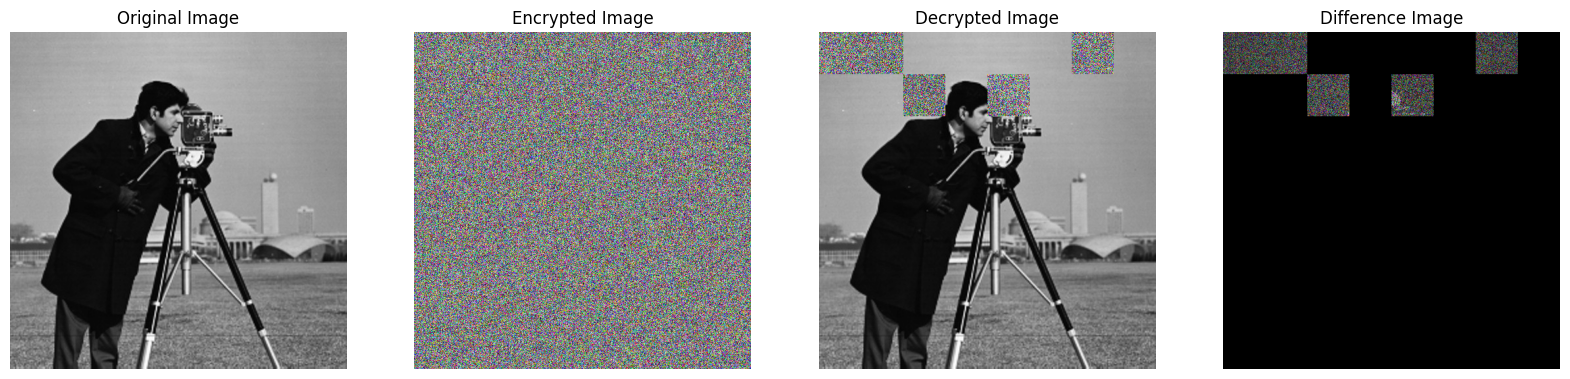

In [49]:
encrypted_image,decrypted_image,modified_decrypted_image = key_annalysis(cameraman_array)
plot_images(decrypted_image,encrypted_image,modified_decrypted_image,encrypted_image.shape)